In [1]:
import pandas as pd
import numpy as np
import quandl
from google.cloud import bigquery
from google.cloud import storage

import pickle
import datetime
import os

from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar

from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.nelson_siegel_model import yield_curve_level


Initializing pandarallel with 20.0 cores
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())    # used to skip over holidays when adding or subtracting business days

In [2]:
PROJECT_ID = "eng-reactor-287421"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/jupyter/ficc/ml_models/sequence_predictors/ahmad_creds.json"
storage_client = storage.Client()
bq_client = bigquery.Client()

In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ficc_training_data_latest/processed_data_2023-06-05-19:33.pkl') as f:
    data = pd.read_pickle(f)

#### Downloading Minute Nelson Siegel coefficients

In [4]:
def sqltodf(sql, bq_client):
    bqr = bq_client.query(sql).result()
    return bqr.to_dataframe()

In [5]:
nelson_params_daily = sqltodf("select * from `eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_daily` order by date asc", bq_client)
nelson_params_daily.set_index("date", drop=True, inplace=True)
nelson_params_daily = nelson_params_daily[~nelson_params_daily.index.duplicated(keep='first')]
nelson_params_daily = nelson_params_daily.transpose().to_dict()

In [6]:
# nelson_params = sqltodf("select * from `eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_minute` order by date desc", bq_client)
nelson_params = sqltodf("Select * from `eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_minute` where date < '2022-06-27' or date > '2022-06-28' order by date asc;", bq_client)
nelson_params.set_index("date", drop=True, inplace=True)
nelson_params = nelson_params[~nelson_params.index.duplicated(keep='first')]

In [7]:
nelson_params_temp = sqltodf("select * from `eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_minute_temp` order by date desc", bq_client)
nelson_params_temp.set_index("date", drop=True, inplace=True)
nelson_params_temp = nelson_params_temp[~nelson_params_temp.index.duplicated(keep='first')]

In [8]:
nelson_params.loc['2022-06-13'] = nelson_params_temp.loc['2022-06-13']

In [9]:
nelson_params.loc['2022-09-26'] = nelson_params_temp.loc['2022-09-26']

In [10]:
nelson_params = pd.concat([nelson_params, nelson_params_temp.loc['2022-06-27']], ignore_index=False)

In [11]:
nelson_params =nelson_params.sort_index(ascending=False)

In [12]:
# nelson_params = pd.concat([nelson_params, nelson_params_temp], axis=0,ignore_index=False,join='outer',sort=True)
# nelson_params = nelson_params[~nelson_params.index.duplicated(keep='first')]
# nelson_params = nelson_params.sort_index()

In [13]:
scalar_params = sqltodf("select * from`eng-reactor-287421.yield_curves_v2.standardscaler_parameters_daily` order by date desc", bq_client)
scalar_params.set_index("date", drop=True, inplace=True)
scalar_params = scalar_params[~scalar_params.index.duplicated(keep='first')]
scalar_params = scalar_params.transpose().to_dict()

In [14]:
shape_parameter  = sqltodf("SELECT *  FROM `eng-reactor-287421.yield_curves_v2.shape_parameters` order by Date desc", bq_client)
shape_parameter.set_index("Date", drop=True, inplace=True)
shape_parameter = shape_parameter[~shape_parameter.index.duplicated(keep='first')]
shape_parameter = shape_parameter.transpose().to_dict()

### Yield curve code

In [15]:
###Functions to transform maturities into the components in the nelson-siegel model
def decay_transformation(t:np.array, L:float):
    return L*(1-np.exp(-t/L))/t

In [16]:
def laguerre_transformation(t, L):
    return (L*(1-np.exp(-t/L))/t) -np.exp(-t/L)

In [17]:
def load_model_parameters(target_datetime, 
                          nelson_params, 
                          scalar_params, 
                          shape_parameter):

    t = target_datetime
    scalar_target_date = (target_datetime - (BUSINESS_DAY * 1)).date()
    target_date = target_datetime.date()
    
    if t.time() < datetime.time(9,30):
        t = t.replace(hour=9, minute=31, second=0)
    
    if t.time() > datetime.time(15,30):
        t = t.replace(hour=15, minute=29, second=0)
    
    nelson_coeff = nelson_params.iloc[nelson_params.index.get_loc(t, method='pad')].values
    
    while scalar_target_date not in scalar_params.keys():
        scalar_target_date = (scalar_target_date - (BUSINESS_DAY * 1)).date()
    
    scalar_coeff = scalar_params[scalar_target_date].values()
    
    try:
        shape_param = shape_parameter[target_date]['L']
    except Exception as e:
        shape_param = shape_parameter[(target_date - (BUSINESS_DAY * 1)).date()]['L']
    
    return nelson_coeff, scalar_coeff, shape_param

In [18]:
def get_scaled_features(t, 
                        exponential_mean, 
                        exponential_std, 
                        laguerre_mean, 
                        laguerre_std,
                        shape_param):
    
    X1 = (decay_transformation(t, shape_param) - exponential_mean)/exponential_std 
    X2 = (laguerre_transformation(t, shape_param) - laguerre_mean)/laguerre_std 
    
    return X1, X2


In [19]:
def predict_ytw(t, 
                const ,
                exponential, 
                laguerre, 
                exponential_mean, 
                exponential_std, 
                laguerre_mean, 
                laguerre_std,
                shape_param):

    X1, X2 = get_scaled_features(t,
                                 exponential_mean,
                                 exponential_std,
                                 laguerre_mean,
                                 laguerre_std,
                                 shape_param)
    
    return const + exponential*X1 + laguerre*X2


In [20]:
def yield_curve_level_real_time(maturity, 
                      target_datetime, 
                      nelson_params, 
                      scalar_params, 
                      shape_paramter):
    if maturity < 0: 
        return None

    t = maturity    
    
    try:
        nelson_siegel_minute_coef, scaler_daily_parameters, shape_param = load_model_parameters(target_datetime, 
                                                                                                nelson_params,
                                                                                                scalar_params, 
                                                                                                shape_paramter)
    except Exception as e:
        raise e 
    
    const, exponential, laguerre = nelson_siegel_minute_coef
    exponential_mean, exponential_std, laguerre_mean, laguerre_std = scaler_daily_parameters
    
    #If the function gets this far, the values are correct. A prediction is made and returned appropriately.
    prediction = predict_ytw(t, 
                             const, 
                             exponential, 
                             laguerre, 
                             exponential_mean, 
                             exponential_std, 
                             laguerre_mean, 
                             laguerre_std,
                             shape_param)
    
    return prediction

### Getting realtime yield curve coefficeints

In [21]:
def get_ficc_ycl_real_time(row):
    duration =  diff_in_days_two_dates(row['calc_date'],row['trade_date'])/NUM_OF_DAYS_IN_YEAR
    ycl = yield_curve_level_real_time(duration, row['trade_datetime'], nelson_params, scalar_params, shape_parameter)
    return ycl

In [22]:
%%time
data['real_time_ficc_ycl'] = data[['trade_datetime','calc_date','settlement_date','trade_date']].parallel_apply(get_ficc_ycl_real_time, axis=1)
# t_data['real_time_ficc_ycl'] = t_data[['trade_datetime','calc_date','settlement_date','trade_date']].apply(get_ficc_ycl_real_time, axis=1)

CPU times: user 1.43 s, sys: 4.72 s, total: 6.16 s
Wall time: 3min 12s


In [23]:
data['delta_ycl'] = data.real_time_ficc_ycl - data.ficc_ycl
# t_data['delta_ycl'] = t_data.real_time_ficc_ycl - t_data.ficc_ycl

In [24]:
# t_data.hist('delta_ycl',bins='auto')

array([[<AxesSubplot:title={'center':'delta_ycl'}>]], dtype=object)

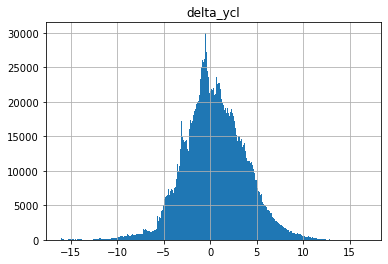

In [25]:
data.hist('delta_ycl',bins='auto')

In [26]:
# data[np.abs(data.delta_ycl) > 15].trade_date.value_counts()

## Last yield spread real time

In [30]:
def get_last_ficc_ycl_real_time(row):
    ficc_ycl_dates = []
    for i in ['last_maturity_date', 'last_next_call_date', 'last_par_call_date', 'last_refund_date']:
        if pd.isnull(row[i]):
            ficc_ycl_dates.append(np.nan)
            continue
        target_date = row[i]
        duration =  diff_in_days_two_dates(target_date.date(),row['last_trade_datetime'])/NUM_OF_DAYS_IN_YEAR
        if row['last_trade_datetime'] < datetime.datetime(2021, 8, 3, 9, 30):
            ficc_ycl_dates.append(yield_curve_level_real_time(duration, 
                                                    pd.to_datetime(datetime.datetime(2021, 8, 3,9,30)), 
                                                    nelson_params, 
                                                    scalar_params, 
                                                    shape_parameter))
        else:
            ficc_ycl_dates.append(yield_curve_level_real_time(duration, 
                                                    row['last_trade_datetime'], 
                                                    nelson_params, 
                                                    scalar_params, 
                                                    shape_parameter))
    
    return ficc_ycl_dates

In [31]:
# data[26200:26201]['last_trade_datetime']#.apply(get_last_ficc_ycl_real_time, axis=1)

In [32]:
# jump = 1
# i = 26190
# while i < 26200:
#     try:
#         temp_df = data[i:i+jump+1].apply(get_last_ficc_ycl_real_time, axis=1)
#         print(f"{i} - {i+jump} is done")
#     except Exception as e:
#         print(f"{i} failed for {i+jump}")
#         break
#     i += jump

In [33]:
temp_df = data.parallel_apply(get_last_ficc_ycl_real_time, axis=1)

In [34]:
data[['last_real_time_ficc_ycl_to_maturity','last_real_time_ficc_ycl_to_next_call','last_real_time_ficc_ycl_to_par_call', 'last_real_time_ficc_ycl_to_refund']] = pd.DataFrame(temp_df.to_list(), index=data.index)

In [35]:
data.last_real_time_ficc_ycl_to_next_call

0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
              ...    
3548128           NaN
3548129    243.417735
3548130    243.417735
3548131           NaN
3548132           NaN
Name: last_real_time_ficc_ycl_to_next_call, Length: 3538249, dtype: float64

In [36]:
data['real_time_ycl_delta'] = np.abs(data.last_ficc_ycl_to_next_call - data.last_real_time_ficc_ycl_to_next_call)

In [37]:
data[(data.real_time_ycl_delta > 80)].last_trade_date.unique()

array([datetime.date(2022, 5, 24), datetime.date(2021, 8, 24),
       datetime.date(2022, 5, 11)], dtype=object)

In [38]:
data[data.rtrs_control_number == 2022092813517000][['last_ficc_ycl_to_next_call','last_real_time_ficc_ycl_to_next_call','last_ficc_ycl_to_maturity','last_real_time_ficc_ycl_to_maturity']]

,last_ficc_ycl_to_next_call,last_real_time_ficc_ycl_to_next_call,last_ficc_ycl_to_maturity,last_real_time_ficc_ycl_to_maturity
2115440,65.844151,158.727342,79.38075,180.976732


In [39]:
data[data.real_time_ycl_delta > 20].last_trade_date.unique()

array([datetime.date(2021, 8, 27), datetime.date(2022, 5, 24),
       datetime.date(2022, 5, 25), datetime.date(2022, 5, 11),
       datetime.date(2022, 5, 10), datetime.date(2022, 5, 6),
       datetime.date(2021, 10, 6), datetime.date(2021, 10, 7),
       datetime.date(2021, 8, 24), datetime.date(2021, 8, 20),
       datetime.date(2022, 7, 6), datetime.date(2021, 8, 12)],
      dtype=object)

In [40]:
data[(data.real_time_ycl_delta > 20) & (data['last_trade_date'] == datetime.datetime(2022,6,13).date())][['cusip','rtrs_control_number','last_real_time_ficc_ycl_to_next_call','last_ficc_ycl_to_next_call']]

,cusip,rtrs_control_number,last_real_time_ficc_ycl_to_next_call,last_ficc_ycl_to_next_call


## Real-time Ficc ycl for all candidate calc dates

In [41]:
def get_ficc_ycl_real_time(row):
    ficc_ycl_dates = []
    for i in ['maturity_date', 'next_call_date', 'par_call_date', 'refund_date']:
        if pd.isnull(row[i]):
            ficc_ycl_dates.append(np.nan)
            continue
        target_date = row[i]
        duration =  diff_in_days_two_dates(target_date.date(),row['trade_date'])/NUM_OF_DAYS_IN_YEAR
        if row['trade_date'].date() < datetime.datetime(2021, 8, 3).date():
            ficc_ycl_dates.append(yield_curve_level_real_time(duration, 
                                                    pd.to_datetime(datetime.datetime(2021, 8, 3,9,30)), 
                                                    nelson_params, 
                                                    scalar_params, 
                                                    shape_parameter))
        else:
            ficc_ycl_dates.append(yield_curve_level_real_time(duration, 
                                                    row['trade_datetime'], 
                                                    nelson_params, 
                                                    scalar_params, 
                                                    shape_parameter))
    
    return ficc_ycl_dates

In [42]:
temp_df = data.parallel_apply(get_ficc_ycl_real_time, axis=1)

In [43]:
data[['real_time_ficc_ycl_to_maturity','real_time_ficc_ycl_to_next_call','real_time_ficc_ycl_to_par_call', 'real_time_ficc_ycl_to_refund']] = pd.DataFrame(temp_df.to_list(), index=data.index)

In [44]:
# data.loc[data.last_refund_date < data.last_settlement_date,'last_real_time_ficc_ycl_to_refund'] = None

In [45]:
# data.loc[data.refund_date < data.settlement_date,'ficc_ycl_to_refund'] = None

## Modified yield real time

In [27]:
def get_modified_ficc_ycl_real_time(row):
    duration =  diff_in_days_two_dates(row['last_calc_date'],row['last_trade_date'])/NUM_OF_DAYS_IN_YEAR
    ycl = yield_curve_level_real_time(duration, row['trade_datetime'], nelson_params, scalar_params, shape_parameter)
    return ycl

In [28]:
data['new_real_time_ficc_ycl'] = data[['trade_datetime','calc_date','settlement_date','last_trade_date','last_calc_date']].parallel_apply(get_modified_ficc_ycl_real_time, axis=1)

In [31]:
data.filter(like='spread').columns

Index(['last_yield_spread', 'yield_spread', 'ficc_treasury_spread'], dtype='object')

In [34]:
data.drop(columns = ['last_ficc_ycl', 'ficc_ycl', 'ficc_ycl_3_month', 'ficc_ycl_1_month',
       'ficc_ycl_to_maturity', 'ficc_ycl_to_next_call', 'ficc_ycl_to_par_call',
       'ficc_ycl_to_refund', 'last_ficc_ycl_to_maturity',
       'last_ficc_ycl_to_next_call', 'last_ficc_ycl_to_par_call',
       'last_ficc_ycl_to_refund', 'new_ficc_ycl',
       'delta_ycl','yield_spread'], inplace=True)

In [21]:
# data['last_durat`ion']  = data[['last_calc_date','last_trade_date']].parallel_apply(lambda row: diff_in_days_two_dates(row['last_calc_date'],row['last_trade_date']), axis=1)

In [35]:
data.to_pickle('processed_data_2023-05-06-10:25.pkl')
upload_data(storage_client, 'ficc_training_data_latest','processed_data_2023-05-06-10:25.pkl')

File processed_data_2023-05-06-10:25.pkl uploaded to ficc_training_data_latest.


In [79]:
data.to_pickle('processed_data_2022-11-22-15:30.pkl')

In [80]:
upload_data(storage_client, 'ficc_training_data_latest','processed_data_2022-11-22-15:30.pkl')

File processed_data_2022-11-22-15:30.pkl uploaded to ficc_training_data_latest.


In [29]:
t = data[data.incorporated_state_code == 'TX']

In [30]:
import matplotlib.pyplot as plt

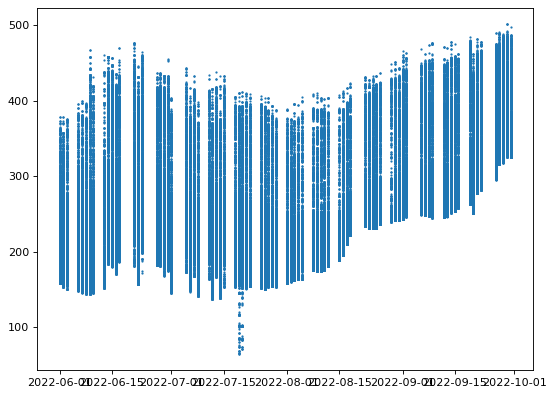

In [31]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(t.trade_date,t.real_time_ficc_ycl,s=1)